In [233]:
import pandas as pd
import plotly.graph_objs as go
import plotly
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from math import floor

In [59]:
# Input: data from the same taxi with columns [id LON LAT STATE GPS_TIME]
def extract_od(df):
    o_df=df[df['STATE'].diff()>0]
    d_df=df[df['STATE'].diff()<0]
    
    #舍去头尾以对齐
    if(len(o_df)<3 or len(d_df)<3):
        return []
    d_index=(d_df[d_df.index>o_df.index[1]].index[0],d_df[d_df.index>o_df.index[-2]].index[0])

    o_df=o_df.iloc[1:-1,:].reset_index(drop=True)
    d_df=d_df.loc[d_index[0]:d_index[1],:].reset_index(drop=True)
 
    od_df=o_df.join(d_df,lsuffix='_O', rsuffix='_D',how='outer')
    od_df=od_df.drop(columns=['STATE_O','id_D','STATE_D'])
    od_df=od_df.rename({'id_O':'id'},axis='columns')
    return od_df

In [60]:
def modify_df(df):
    df.columns=['id','LON','LAT','STATE','GPS_TIME']
    df=df.drop(df[df['LON']<1].index)
    df=df.sort_values('GPS_TIME')
    df=df.reset_index(drop=True)
    return df

In [172]:
df=pd.DataFrame([])
FilePath='E:/WorkSpace/py/travel_flow/data/OD'
for root, dirs, files in os.walk(FilePath):
    for file in files:
        df_taxi=modify_df(pd.read_csv(os.path.join(root, file),encoding='utf-8'))
        groups = df_taxi.groupby('id')
        for label,group in groups:
            df=df.append(extract_od(group))
        break
# OD_Matrix.hist('LAT_D',bins=50)

In [173]:
LON_MIN,LON_MAX,LAT_MIN,LAT_MAX=[120.5,120.8,27.9,28.05]
OD_Matrix=df[(df['LAT_O']<LAT_MAX) & (df['LAT_O']>LAT_MIN) & (df['LAT_D']>LAT_MIN) & (df['LAT_D']<LAT_MAX) &\
              (df['LON_O']<LON_MAX) & (df['LON_O']>LON_MIN) & (df['LON_D']>LON_MIN) & (df['LON_D']<LON_MAX)].copy()
OD_Matrix

,id,LON_O,LAT_O,GPS_TIME_O,LON_D,LAT_D,GPS_TIME_D
2,浙CT100053,120.719475,27.992098,2020/3/5 13:54:06,120.713615,27.986214,2020/3/5 13:56:46
3,浙CT100053,120.718765,27.991260,2020/3/5 14:10:14,120.680470,27.960117,2020/3/5 14:20:29
4,浙CT100053,120.693670,27.982546,2020/3/5 14:36:31,120.692800,27.991170,2020/3/5 14:41:07
5,浙CT100053,120.691880,27.991514,2020/3/5 14:41:26,120.632996,27.984455,2020/3/5 15:13:03
6,浙CT100053,120.635920,27.989120,2020/3/5 15:47:24,120.674620,27.956068,2020/3/5 16:05:35
...,...,...,...,...,...,...,...
2,浙CT99928,120.632065,28.018452,2020/3/5 13:24:50,120.651330,28.024640,2020/3/5 13:33:18
3,浙CT99928,120.645670,28.023237,2020/3/5 13:52:58,120.661000,28.024984,2020/3/5 14:00:41
4,浙CT99928,120.649925,28.026640,2020/3/5 14:07:43,120.662790,27.985730,2020/3/5 14:22:43
5,浙CT99928,120.665634,28.026520,2020/3/5 15:16:10,120.653430,28.015741,2020/3/5 15:24:59


In [177]:
OD_Matrix['GPS_TIME_O']= pd.to_datetime(OD_Matrix['GPS_TIME_O'])

In [230]:
def gen_OdList(df,grids):
    step_lon=(LON_MAX-LON_MIN)/grids
    step_lat=(LAT_MAX-LAT_MIN)/grids
    ox=[floor(x) for x in ((df['LON_O']-LON_MIN)/step_lon)]
    oy=[floor(x) for x in ((df['LAT_O']-LAT_MIN)/step_lat)]
    dx=[floor(x) for x in ((df['LON_D']-LON_MIN)/step_lon)]
    dy=[floor(x) for x in ((df['LAT_D']-LAT_MIN)/step_lat)]
    OD=np.zeros([grids**2,grids**2],int)
    for x1,y1,x2,y2 in zip(ox,oy,dx,dy):
        OD[x1+y1*grids,x2+y2*grids]+=1
    return OD

DataLists=[]
groups_d=OD_Matrix.groupby(pd.Grouper(key='GPS_TIME_O',freq='D'))
for _,group_d in groups_d:
    DataList=[]
    groups_h=group_d.groupby(pd.Grouper(key='GPS_TIME_O',freq='H'))
    for _,group_h in groups_h:
        DataList.append(gen_OdList(group_h,4))
    DataLists.append(DataList)


In [254]:
OD_DAY_ONE_NINE=DataLists[0][8]
sum(sum(OD_DAY_ONE_NINE))

1532

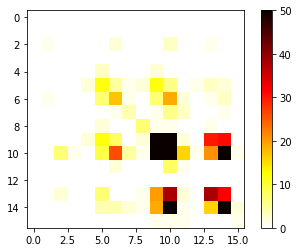

In [255]:
plt.imshow(OD_DAY_ONE_NINE, cmap=plt.cm.hot_r, vmin=0, vmax=50)
plt.colorbar()
plt.show()